# 이미지 증강(Image Augmentation) 적용하기

## 샘플 데이터셋 다운로드
- 본 튜토리얼 에서는 kaggle에 공개된 `cats and dogs` 데이터셋을 활용합니다.

In [1]:
import urllib.request
import zipfile
import glob
import os
from PIL import Image, UnidentifiedImageError, ImageFile


# 이미지 Validation을 수행하고 Validate 여부를 return 합니다.
def validate_image(filepath):
    # image extensions
    image_extensions = ['.jpg', '.jpeg', '.jfif', '.pjpeg', '.pjp','.png', '.avif', '.gif']
    # 이미지 파일 확장자를 가진 경우
    if any(filepath.endswith(s) for s in image_extensions):   
        try:
            # PIL.Image로 이미지 데이터를 로드하려고 시도합니다.
            img = Image.open(filepath).convert('RGB')
            img.load()
        except UnidentifiedImageError: # corrupt 된 이미지는 해당 에러를 출력합니다.
            print(f'Corrupted Image is found at: {filepath}')
            return False
        except (IOError, OSError): # Truncated (잘린) 이미지에 대한 에러를 출력합니다.
            print(f'Truncated Image is found at: {filepath}')
            return False
        else:
            return True
    else:
        print(f'File is not an image: {filepath}')
        return False

def download_dataset(download_url, folder, default_folder='tmp'):
    # 데이터셋을 다운로드 합니다.
    urllib.request.urlretrieve(download_url, 'datasets.zip')

    # 다운로드 후 tmp 폴더에 압축을 해제 합니다.
    local_zip = 'datasets.zip'
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall(f'{default_folder}/')
    zip_ref.close()

    # 잘린 이미지 Load 시 경고 출력 안함
    ImageFile.LOAD_TRUNCATED_IMAGES = True

    # image 데이터셋 root 폴더
    root = f'{default_folder}/{folder}' 

    dirs = os.listdir(root)

    for dir_ in dirs:
        folder_path = os.path.join(root, dir_)
        files = os.listdir(folder_path)

        images = [os.path.join(folder_path, f) for f in files]
        for img in images:
            valid = validate_image(img)
            if not valid:
                # corrupted 된 이미지 제거
                os.remove(img)

    folders = glob.glob(f'{default_folder}/{folder}/*')
    print(folders)
    return folders

In [2]:
# 개, 고양이 데이터셋 다운로드를 받습니다.
# 받은 데이터는 tmp/PetImages 폴더 안에 저장됩니다.
# 중간에 Truncated 된 이미지가 존재합니다.
download_dataset('https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip', 'PetImages')

File is not an image: tmp/PetImages/Dog/Thumbs.db


/opt/conda/envs/py37/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupted Image is found at: tmp/PetImages/Dog/11702.jpg
File is not an image: tmp/PetImages/Cat/Thumbs.db
Corrupted Image is found at: tmp/PetImages/Cat/666.jpg
['tmp/PetImages/Dog', 'tmp/PetImages/Cat']


['tmp/PetImages/Dog', 'tmp/PetImages/Cat']

## 학습에 활용할 데이터셋 준비

In [3]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# 랜덤 시드 설정
torch.manual_seed(321)

# 이미지 크기를 224 x 224 로 조정합니다
IMAGE_SIZE = 224

`torchvision.datasets.ImageFolder`

- `root`: 이미지 폴더가 위치한 루트 폴더의 경로를 입력합니다.
- `transform`: 이미지 변형에 대한 함수를 입력합니다.
- `traget_transform`: `target` 값에 대한 변형하는 함수를 입력합니다. 원핫인코딩을 적용할 수 있습니다.
- `loader`: 이미지 로더 함수를 적용할 수 있습니다.
- `is_valid_file`: 이미지의 corrupt여부를 체크할 수 있습니다.

In [4]:
# 이미지 폴더로부터 데이터를 로드합니다.
original_dataset = ImageFolder(root='tmp/PetImages',                            # 다운로드 받은 폴더의 root 경로를 지정합니다.
                               transform=transforms.Compose([                   # Resize 후 정규화(0~1)를 수행합니다.
                                   transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # 개와 고양이 사진 파일의 크기가 다르므로, Resize로 맞춰줍니다.
                                   transforms.ToTensor()
                               ]))

In [5]:
# 데이터 로더를 생성합니다.
original_loader = DataLoader(original_dataset, # 이전에 생성한 original_dataset를 로드 합니다.
                             batch_size=16,    # 배치사이즈
                             shuffle=False,     # 셔플 여부
                             num_workers=1 
                            )

In [6]:
# 1개의 배치를 추출합니다.
original_images, labels = next(iter(original_loader))

# 이미지의 shape을 확인합니다. 224 X 224 RGB 이미지 임을 확인합니다. 
# (batch_size, channel, height, width)
original_images.shape

torch.Size([16, 3, 224, 224])

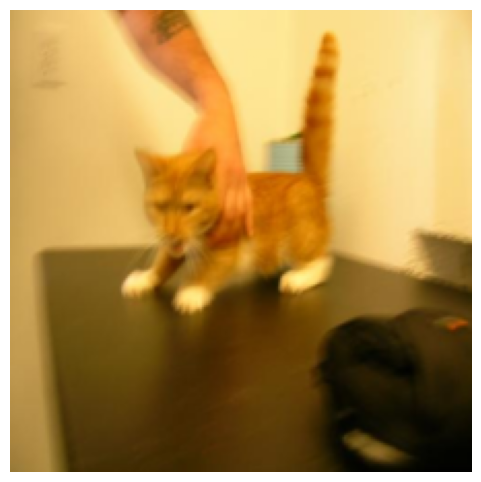

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
# permute로 이미지의 shape를 다음과 같이 변경합니다
# (height, width, channel)
plt.imshow(original_images[0].permute(1, 2, 0))
plt.grid(False)
plt.axis('off')
plt.show()

개와 고양이 이미지 데이터셋의 원본 사진을 시각화 합니다. 처음 3장의 이미지만 출력합니다.

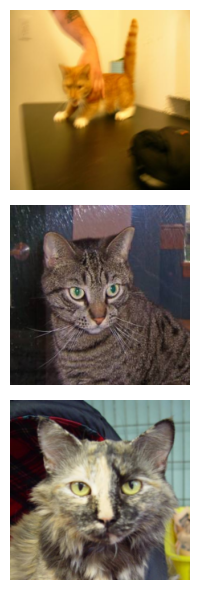

In [8]:
fig, axes = plt.subplots(3, 1)
fig.set_size_inches(4, 6)

for idx in range(3):
    axes[idx].imshow(original_images[idx].permute(1, 2, 0))
    axes[idx].set_axis_off()
fig.tight_layout()
plt.show()

이미지 변환기(Image Transforms)는 [공식도큐먼트 링크](https://pytorch.org/vision/stable/transforms.html)에서 세부 함수의 인자(parameter)와 사용 예시를 확인할 수 있습니다. 아래는 몇 가지 함수를 적용해보고 원본 이미지와 비교하여 시각화한 결과입니다.

In [9]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),                    # 개와 고양이 사진 파일의 크기가 다르므로, Resize로 맞춰줍니다.
    transforms.CenterCrop((IMAGE_SIZE, IMAGE_SIZE)),  # 중앙 Crop
    transforms.ToTensor()
])

# 이미지 폴더로부터 데이터를 로드합니다.
transform_dataset = ImageFolder(root='tmp/PetImages',                  # 다운로드 받은 폴더의 root 경로를 지정합니다.
                                transform=image_transform)

# 데이터 로더를 생성합니다.
transform_loader = DataLoader(transform_dataset, # 이전에 생성한 transform_dataset를 적용합니다.
                              batch_size=16,     # 배치사이즈
                              shuffle=False,      # 셔플 여부
                              num_workers=1 
                             )

In [10]:
transform_images, labels = next(iter(transform_loader))

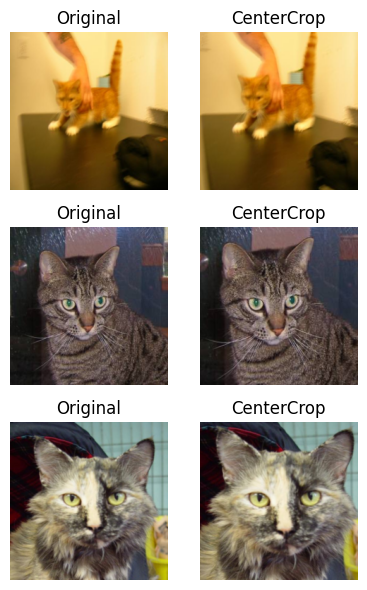

In [11]:
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(4, 6)

for idx in range(3):
    axes[idx, 0].imshow(original_images[idx].permute(1, 2, 0))
    axes[idx, 0].set_axis_off()
    axes[idx, 0].set_title('Original')
    axes[idx, 1].imshow(transform_images[idx].permute(1, 2, 0))
    axes[idx, 1].set_axis_off()
    axes[idx, 1].set_title('CenterCrop')
fig.tight_layout()
plt.show()

In [12]:
def create_loader(transform):
    # 이미지 폴더로부터 데이터를 로드합니다.
    transform_dataset = ImageFolder(root='tmp/PetImages', # 다운로드 받은 폴더의 root 경로를 지정합니다.
                                    transform=transform)

    # 데이터 로더를 생성합니다.
    transform_loader = DataLoader(transform_dataset,      # 이전에 생성한 transform_dataset를 적용합니다.
                                  batch_size=16,          # 배치사이즈
                                  shuffle=False,          # 셔플 여부
                                  num_workers=1 
                                 )
    
    transform_images, labels = next(iter(transform_loader))
    
    fig, axes = plt.subplots(3, 2)
    fig.set_size_inches(4, 6)

    for idx in range(3):
        axes[idx, 0].imshow(original_images[idx].permute(1, 2, 0))
        axes[idx, 0].set_axis_off()
        axes[idx, 0].set_title('Original')
        axes[idx, 1].imshow(transform_images[idx].permute(1, 2, 0))
        axes[idx, 1].set_axis_off()
        axes[idx, 1].set_title('Transformed')
        
    fig.tight_layout()
    plt.show()

`ColorJitter`
- `brightness`: 밝기 조절 (0~1)
- `contrast`: 대비 조절 (0~1)
- `saturation`: 채도 조절 (0~1)
- `hue`: 휴 조절 (-0.5~0.5)

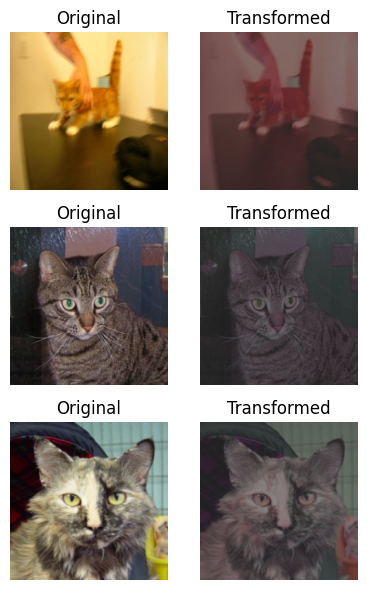

In [13]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),              
    # ColorJitter 적용
    transforms.ColorJitter(brightness=(0.5, 0.9), 
                           contrast=(0.4, 0.8), 
                           saturation=(0.7, 0.9),
                           hue=(-0.2, 0.2),
                          ),
    transforms.ToTensor()
])

create_loader(image_transform)

`RandomHorizontalFlip(p=0.5)`
- Horizontal Flip의 확률을 조절합니다. 

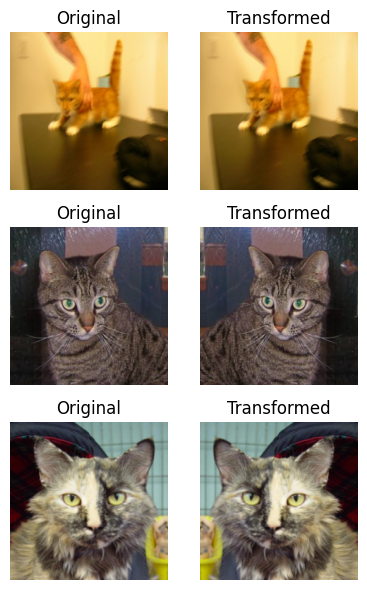

In [14]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),              
    # RandomHorizontalFlip 적용
    transforms.RandomHorizontalFlip(p=0.8),
    transforms.ToTensor()
])

create_loader(image_transform)

`GaussianBlur(kernel_size, sigma=(0.1, 2.0))`
- `kernel_size`: 가우시안 커널의 크기
- `sigma`: 커널의 Standard Deviation

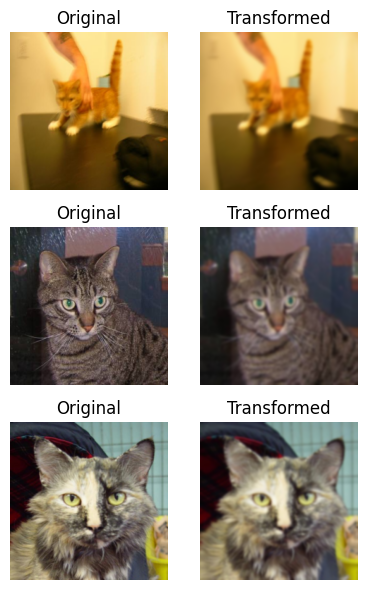

In [15]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),              
    # GaussianBlur 적용
    transforms.GaussianBlur(kernel_size=(19, 19), sigma=(1.0, 2.0)),
    transforms.ToTensor()
])

create_loader(image_transform)

`RandomRotation(degrees, interpolation=InterpolationMode.NEAREST, expand=False, center=None, fill=0)`
- `degrees`: 로테이션에 적용할 각도 (min, max)
- `interpolation`: 기본 값(`InterpolationMode.NEAREST`). `InterpolationMode.BILINEAR` 추가 적용 가능
- `fill`: 기본 값(0). 픽셀 값으로 채울 값 지정.

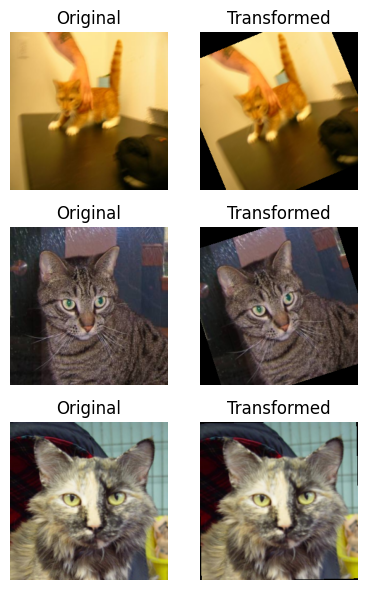

In [34]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),              
    # RandomRotation 적용
    transforms.RandomRotation(degrees=(-30, 30), interpolation=transforms.InterpolationMode.BILINEAR, fill=0),
    transforms.ToTensor()
])

create_loader(image_transform)

`Pad(padding, fill=0, padding_mode='constant')`
- `padding`: 단일 값으로 지정시 left, right, top, bottom에 동일하게 패딩 적용. 2개 지정시 left/right, top/bottom 순차 적용. 4개 적용시 left, top, right, bottom 순서대로 적용
- `fill`: 단일 값으로 지정시 해당 값으로 픽셀 값으로 채움. tuple 형태로 3개 지정시 RGB 채널에 순차 적용.
- `padding_mode`: 기본 값은 `constant`. `edge`, `reflect`, `symmetric`으로 변경 가능

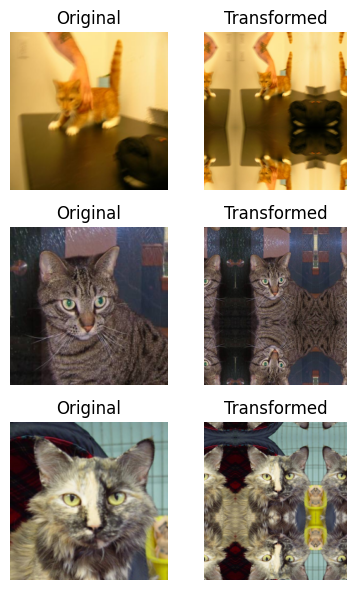

In [29]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),              
    # Pad 적용
    transforms.Pad(padding=(100, 50, 100, 200), fill=255, padding_mode='symmetric'),
    transforms.ToTensor()
])

create_loader(image_transform)

`RandomAdjustSharpness(sharpness_factor, p=0.5)`
- `sharpness_factor`: 선명도를 얼마나 조절할 것인가. 0은 흐릿한 이미지를 제공하고 1은 원본 이미지를 제공하는 반면 2는 선명도를 2배 증가시킵니다.
- `p`: 선명도(sharpness) 적용 확률


주어진 확률로 이미지의 선명도를 임의로 조정합니다. 이미지가 토치 텐서인 경우, […, 1 또는 3, H, W] 모양을 가질 것으로 예상되며, 여기서 ...는 임의의 수의 선행 차원을 의미합니다.

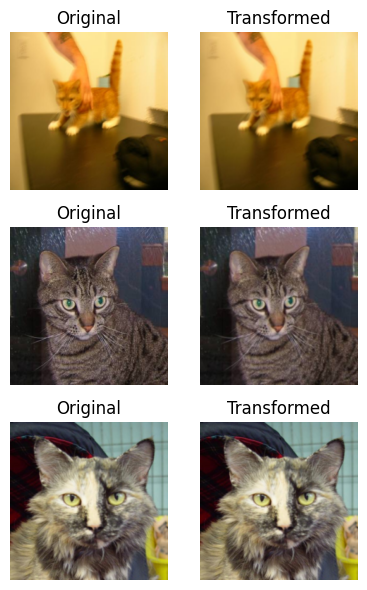

In [32]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),              
    # RandomAdjustSharpness 적용
    transforms.RandomAdjustSharpness(sharpness_factor=0.1, p=0.9),
    transforms.ToTensor()
])

create_loader(image_transform)

**데이터로부터 학습 증강 전략**에 기반한 자동증강 데이터 증강 방법. 


`AutoAugment(policy: AutoAugmentPolicy = AutoAugmentPolicy.IMAGENET, interpolation: InterpolationMode = InterpolationMode.NEAREST, fill: Optional[List[float]] = None)`
- `policy`: torchvision.transforms에 의해 정의된 원하는 정책 열거형입니다. 기본값은 `transforms.autoaugment.AutoAugmentPolicy`입니다(ImageNet).
- `interpolation`: torchvision.transforms에 의해 정의된 원하는 보간 모드. 기본 값(`InterpolationMode.NEAREST`). `InterpolationMode.BILINEAR` 추가 적용 가능. 
- `fill`: 변환된 이미지 외부 영역의 픽셀 채우기 값.

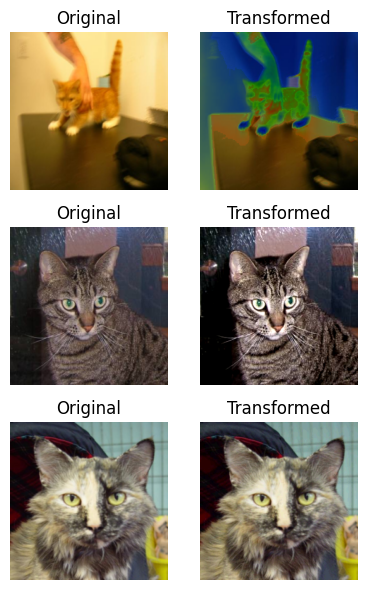

In [36]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),              
    # AutoAugment 적용
    transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.IMAGENET, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor()
])

create_loader(image_transform)